This one is getting ./AS13_reduc/data/AS13_stgdir_labelGeneric.csv

In [1]:
%%capture
!pip install codecarbon

In [2]:
#!pip uninstall wandb

In [3]:
# run this first cell and then do "restart and run all" from the run menu
!pip install -U accelerate

In [4]:
# Flaubert asks for this
!pip install sacremoses

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 28.3 MB/s eta 0:00:00


In [5]:
import os
os.environ["WANDB_MODE"] = "disabled"

##### CONFIG ####

dataset_name = "AS13_stgdir_labelGeneric"

model_dict = {1: "camembert-base", 2: "cmarkea/distilcamembert-base", 3: "bert-base-multilingual-cased", 4: "distilbert-base-multilingual-cased",
              5: "bert-base-multilingual-uncased", 6: "distilbert-base-multilingual-uncased",
              7: "flaubert/flaubert_base_cased", 8: "flaubert/flaubert_base_uncased"}

model_key = 7
model_ckpt = model_dict[model_key]
fraction_kept = 10 # can only be 100, 50, 25, 10, 5
run_number = 5

batch_size = 16
max_epochs = 40
assert not(fraction_kept < 50 and max_epochs < 10)

use_drive = False
use_drive_for_cm = True
save_model = False

# output dir format (below)
#output_dir=f"{model_ckpt}__finetuned__{dataset_name}__{fraction_kept}__{run_number}"

In [6]:
import os
if use_drive_for_cm:
  from google.colab import drive
  drive.mount("/content/drive")
  out_dir = "/content/drive/MyDrive/___tests_ft_d25"
  model_outname = model_ckpt.replace("/", "-")
  out_exp = os.path.join(f"stgcls_reps__{model_outname}__{str.zfill(str(fraction_kept), 3)}__{run_number}")
  out_dir_exp = os.path.join(out_dir, out_exp)
  if not os.path.exists(out_dir_exp):
    os.mkdir(out_dir_exp)

Mounted at /content/drive


In [7]:
!ls /content/drive/MyDrive/___tests_ft_d25

___d25-exps
stgcls_reps__flaubert-flaubert_base_cased__010__4
stgcls_reps__flaubert-flaubert_base_cased__010__5
stgcls_reps__flaubert-flaubert_base_cased__100__4
stgcls_reps__flaubert-flaubert_base_cased__100__5
stgcls_reps__flaubert-flaubert_base_uncased__100__1


In [8]:
assert fraction_kept in [100*x for x in (1, 0.5, 0.25, 0.1, 0.05)]
assert run_number in (1, 2, 3, 4, 5)

In [9]:
# fraction kept to color map
clrmap_dict = {100: "Greens", 50: "Blues", 25: "Purples", 10: "Oranges", 5: "Reds"}
assert fraction_kept in clrmap_dict

In [10]:
!python --version

Python 3.10.12


In [11]:
!mkdir data

In [12]:
! pip install transformers

In [13]:
! pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [14]:
! pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.5 MB/s eta 0:00:00


In [15]:
!pip install sentencepiece

In [16]:
import os

from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import EarlyStoppingCallback, IntervalStrategy
from transformers import FlaubertModel, FlaubertTokenizer
from datasets import Features, Value, ClassLabel, Dataset, DatasetDict
import evaluate
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import torch

In [17]:
from sklearn.metrics import classification_report

J'ai téléversé les données sur mon serveur

In [18]:
![[ ! -d data ]] && mkdir data || echo "data directory exists"
#![[ ! -f data/AS13_stgdir_clean.csv ]] && wget -P data https://prf1.org/stgs/as-did/AS13_stgdir_clean.csv || echo "dataset already downloaded"
![[ ! -f data/AS13_stgdir_labelGeneric.csv ]] && wget -P data https://prf1.org/stgs/as-did/AS13_stgdir_labelGeneric.csv || echo "dataset already downloaded"

data directory exists
--2024-11-19 11:31:35--  https://prf1.org/stgs/as-did/AS13_stgdir_labelGeneric.csv
Resolving prf1.org (prf1.org)... 85.214.103.246
Connecting to prf1.org (prf1.org)|85.214.103.246|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1017742 (994K) [text/csv]
Saving to: ‘data/AS13_stgdir_labelGeneric.csv’

AS13_stgdir_labelGe 100%[===================>] 993.89K   891KB/s    in 1.1s    

2024-11-19 11:31:37 (891 KB/s) - ‘data/AS13_stgdir_labelGeneric.csv’ saved [1017742/1017742]



Recette pour éléchargement fichiers qui sont sur Drive sur la session Colab (sans monter le Drive) (pas nécessaire ici mais comme idée pour d'autres fichiers).
C'est un fichier quelconque non relié à la tâche qui a été utilisé pour tester.

In [19]:
mydf = "data/AS13_stgdir_labelGeneric.csv"

In [20]:
labelCol = 'labelGeneric'

In [21]:
import pandas as pd
AS13_df = pd.read_csv(mydf, sep="|", dtype={'description': 'object',
                                            labelCol: 'category'})

In [22]:
AS13_df = AS13_df.drop_duplicates()
AS13_df = AS13_df.dropna(how='any')
AS13_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14613 entries, 0 to 25821
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   description   14613 non-null  object  
 1   labelGeneric  14613 non-null  category
dtypes: category(1), object(1)
memory usage: 243.2+ KB


In [23]:
df = AS13_df

In [24]:
df['labelGeneric'].value_counts()

,count
labelGeneric,
music,2863
action,2467
toward,2144
exit,1295
object,1130
setting,982
delivery,962
entrance,646
movement,583


In [25]:
# Liste de classes et ajout d'un identifiant numérique pour chaque classe
class_names = sorted(AS13_df[labelCol].unique().categories.to_list())
label2id = {class_names[i]:i for i in range(len(class_names))}
id2label = {i:class_names[i] for i in range(len(class_names))}

In [26]:
#class_names, label2id, id2label

In [27]:
# Paramètres

#batch_size = 32 # orig was 64 but I'm going down given CUDA OutOfMemory error
batch_size = 16 # for camembert-base, trying 16
# Proportion des données qui sera utilisée
scale = 0.2 # this is not used anywhere, can we remove it?

In [28]:
# nv dataFrame
data_df = pd.DataFrame()
data_df['text'] = AS13_df.description
# La classe cible est la région (province) sous forme d'identifiant numérique
data_df['label'] = AS13_df[labelCol].map(label2id)

In [29]:
data_df = data_df.reset_index(drop=True)

In [30]:
# Transformation du DataFrame en objet de type Dataset utilisé par HuggingFace
stgtype_features = Features({'text': Value('string'),
                              'label': ClassLabel(names=class_names)})
data = Dataset.from_pandas(data_df, features=stgtype_features)


In [31]:
# Découpage en (train + validation) (this part will be reduced to 50%, 25% and so on to compare quality) et (test).
# The test part is supposed to always stay the same size and with the same examples

In [32]:
TRAIN_FULL, TRAIN_REDUCED = False, False
size_to_exclude = (100 - fraction_kept)/100
if size_to_exclude == 0:
  TRAIN_FULL = True
  print("FULL TRAIN")
else:
  TRAIN_REDUCED = True
  print(f"REDUCED TRAIN, KEEPING {fraction_kept}%")

REDUCED TRAIN, KEEPING 10%


In [33]:
print(f"SIZE TO EXCLUDE IS {size_to_exclude}")

SIZE TO EXCLUDE IS 0.9


In [34]:
if TRAIN_REDUCED:
  trainvalid_test = data.train_test_split(test_size=0.2, shuffle=True, seed=12)
  trainvalid_reduced = trainvalid_test['train'].train_test_split(test_size=size_to_exclude, shuffle=True, seed=12)
  trainvalid_reduced_trainvalid = trainvalid_reduced['train'].train_test_split(test_size=0.2, shuffle=True, seed=12)
  dataset = DatasetDict({"train": trainvalid_reduced_trainvalid["train"],
                         "valid": trainvalid_reduced_trainvalid["test"],
                         "test": trainvalid_test["test"]})
elif TRAIN_FULL:
  trainvalid_test = data.train_test_split(test_size=0.2, shuffle=True, seed=12)
  trainvalid_trainvalid = trainvalid_test["train"].train_test_split(test_size=0.2, shuffle=True, seed=12)
  dataset = DatasetDict({"train": trainvalid_trainvalid["train"],
                         "valid": trainvalid_trainvalid["test"],
                         "test": trainvalid_test["test"]})

In [35]:
data = dataset

In [36]:
data

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 935
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 234
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2923
    })
})

In [37]:
#steps = (epoch * examples)/batch size
total_steps = (6 * len(df))/16
total_steps

5479.875

In [38]:
# this is unused unless use steps as strategy in training args
epoch_size = len(data['train'])/batch_size

In [39]:
print(f"EPOCH SIZE IS: {epoch_size}")

EPOCH SIZE IS: 58.4375


When needed, export the dataset to verify later that it's indeed the same for all experiments

In [40]:
if False and use_drive:
  from google.colab import drive
  drive.mount("/content/drive")
  dataset_bkps = "/content/drive/MyDrive/___wv/datasets"
  current_dataset = "AS13_stgdir_labelGeneric_trainvalid_retest_uncased_25_pr_2"
  os.mkdir(os.path.join(dataset_bkps, current_dataset))
  for split, split_data in data.items():
    split_data.to_csv(Path(dataset_bkps) / current_dataset / f"{current_dataset}-{split}.csv")
    print(f"!head -n5 {split_path_str}")

In [41]:
#!head -n5 /content/drive/MyDrive/___wv/datasets/AS13_stgdir_labelGeneric_trainvalid_retest_uncased/AS13_stgdir_labelGeneric_trainvalid_retest_uncased-train.csv
#!head -n5 /content/drive/MyDrive/___wv/datasets/AS13_stgdir_labelGeneric_trainvalid_retest_uncased/AS13_stgdir_labelGeneric_trainvalid_retest_uncased-valid.csv
#!head -n5 /content/drive/MyDrive/___wv/datasets/AS13_stgdir_labelGeneric_trainvalid_retest_uncased/AS13_stgdir_labelGeneric_trainvalid_retest_uncased-test.csv

In [42]:
model_ckpt

'flaubert/flaubert_base_cased'

In [43]:
#!pip install sacremoses

In [44]:
if model_key in range(7,11):
  do_lc = False if model_key == 7 else True
  assert model_key in (7,8)
  tokenizer = FlaubertTokenizer.from_pretrained(model_ckpt, do_lowercase=do_lc)
else:
  # Chargement du tokéniseur pré-entraîné correspondant au modèle utilisé
  tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.56M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/896k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

In [45]:
def preprocess_function(examples):
    return tokenizer(examples["text"], padding=True, truncation=True)

In [46]:
%pdb

Automatic pdb calling has been turned ON


In [47]:
# Tokenisation de la totalité des données : chaque unité est remplacée par un identifiant numérique
tokenized_data = data.map(preprocess_function, batched=True, batch_size=None)

Map:   0%|          | 0/935 [00:00<?, ? examples/s]

Map:   0%|          | 0/234 [00:00<?, ? examples/s]

Map:   0%|          | 0/2923 [00:00<?, ? examples/s]

In [48]:
# Taille du vocabulaire
tokenizer.vocab_size

68729

In [49]:
# Taille de contexte maximum
tokenizer.model_max_length

512

In [50]:
accuracy = evaluate.load("accuracy")

In [51]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    acc = accuracy.compute(predictions=predictions, references=labels)
    return acc

In [52]:
#!curl ipinfo.io

In [53]:
from codecarbon import OfflineEmissionsTracker
tracker_before_train = OfflineEmissionsTracker(country_iso_code="FRA", save_to_file=True, output_dir=out_dir_exp,
                                               output_file=f"em_before_train__{os.path.basename(out_dir_exp)}.csv",
                                               log_level="critical")
tracker_before_train.start()

[codecarbon INFO @ 11:31:58] offline tracker init


In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if model_key in range(7000,1100):
  model = FlaubertModel.from_pretrained(model_ckpt).to(device)
else:
  model = AutoModelForSequenceClassification.from_pretrained(
      model_ckpt, num_labels=len(class_names), id2label=id2label, label2id=label2id
  ).to(device)

model.safetensors:   0%|          | 0.00/553M [00:00<?, ?B/s]

Some weights of FlaubertForSequenceClassification were not initialized from the model checkpoint at flaubert/flaubert_base_cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [55]:
batch_size=16

In [56]:
from math import ceil
intended_eval_steps = ceil(len(data['train'])/batch_size)

In [57]:
# was recommended at https://stackoverflow.com/questions/69087044/early-stopping-in-bert-trainer-instances, but seems
# to no longer be necessary
# on 'eval_loss' as metric https://discuss.huggingface.co/t/early-stopping-training-using-validation-loss-as-the-metric-for-best-model/31378
if False:
  training_args = TrainingArguments(
      output_dir=f"{model_ckpt}__finetuned__{dataset_name}__{fraction_kept}__{run_number}",
      learning_rate=2e-5,
      num_train_epochs=max_epochs,
      evaluation_strategy=IntervalStrategy.STEPS,
      eval_steps = intended_eval_steps,
      save_steps = intended_eval_steps,
      save_total_limit = 3,
      per_device_train_batch_size=batch_size,
      per_device_eval_batch_size=batch_size,
      weight_decay=0.01,
      save_strategy=IntervalStrategy.STEPS,
      load_best_model_at_end=True,
      metric_for_best_model='eval_loss',
  )

In [58]:
training_args = TrainingArguments(
    output_dir=f"{model_ckpt}__finetuned__{dataset_name}__{fraction_kept}__{run_number}",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=max_epochs,
    weight_decay=0.01,
    save_total_limit = 3,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Now we use train et validation for the fine-tuning. We'll only use test to test the model after fine-tuning

In [59]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["valid"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

<ipython-input-59-99445cd2dcae>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [60]:
tracker_before_train.stop()

/usr/local/lib/python3.10/dist-packages/codecarbon/output_methods/file.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame.from_records([dict(total.values)])])


7.681356886022028e-06

In [61]:
batch_size

16

In [62]:
print(f"## FINE TUNING A {model_ckpt} MODEL ##")

## FINE TUNING A flaubert/flaubert_base_cased MODEL ##


In [63]:
tracker_train = OfflineEmissionsTracker(country_iso_code="FRA", save_to_file=True, output_dir=out_dir_exp,
                                        output_file=f"em_train__{os.path.basename(out_dir_exp)}.csv",
                                        log_level="critical")
tracker_train.start()

In [64]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.795803,0.410256
2,No log,1.519902,0.512821
3,No log,1.146468,0.675214
4,No log,0.890718,0.747863
5,No log,0.788393,0.782051
6,No log,0.856651,0.786325
7,No log,0.876684,0.816239
8,No log,0.844310,0.824786


TrainOutput(global_step=472, training_loss=0.8694553698523569, metrics={'train_runtime': 181.6946, 'train_samples_per_second': 205.84, 'train_steps_per_second': 12.989, 'total_flos': 767370151017360.0, 'train_loss': 0.8694553698523569, 'epoch': 8.0})

In [65]:
tracker_train.stop()

/usr/local/lib/python3.10/dist-packages/codecarbon/output_methods/file.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame.from_records([dict(total.values)])])


0.00035880145312870335

In [66]:
tracker_predict = OfflineEmissionsTracker(country_iso_code="FRA", save_to_file=True, output_dir=out_dir_exp,
                                          output_file=f"em_predict__{os.path.basename(out_dir_exp)}.csv",
                                          log_level="critical")
tracker_predict.start()

In [67]:
preds_output = trainer.predict(tokenized_data['test'])

In [68]:
tracker_predict.stop()

/usr/local/lib/python3.10/dist-packages/codecarbon/output_methods/file.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame.from_records([dict(total.values)])])


9.752297375263806e-05

In [69]:
y_preds = np.argmax(preds_output.predictions, axis=1)

In [70]:
y_test = tokenized_data['test']['label']

In [71]:
labels = tokenized_data['test'].features['label'].names

In [72]:
# fraction kept to color map
clrmap_dict = {100: "Greens", 50: "Blues", 25: "Purples", 10: "Oranges", 5:"Reds"}

In [73]:
fraction_kept

10

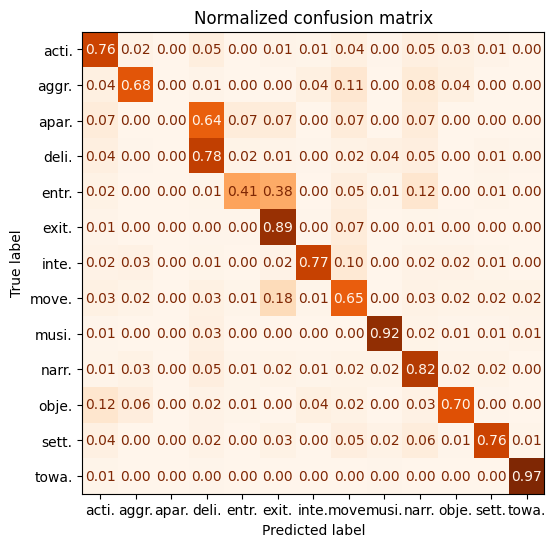

In [74]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    cm_no_norm = confusion_matrix(y_true, y_preds)
    fig, ax = plt.subplots(figsize=(6, 6))
    labels_for_fig = [l[0:4]+'.' for l in labels]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels_for_fig)
    #disp.plot(cmap="Purples", values_format=".2f", ax=ax, colorbar=False)
    disp.plot(cmap=clrmap_dict[fraction_kept], values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
    return cm, cm_no_norm

cm_ob, cm_rawf_ob = plot_confusion_matrix(y_preds, y_test, labels)

In [75]:
print("Classification report:\n\n{}".format(classification_report(y_test, y_preds, digits=4)))

Classification report:

              precision    recall  f1-score   support

           0     0.8506    0.7613    0.8035       486
           1     0.6145    0.6800    0.6456        75
           2     0.0000    0.0000    0.0000        14
           3     0.6789    0.7840    0.7277       213
           4     0.8000    0.4062    0.5389       128
           5     0.7059    0.8926    0.7883       242
           6     0.7900    0.7745    0.7822       102
           7     0.4753    0.6471    0.5480       119
           8     0.9653    0.9151    0.9395       577
           9     0.5185    0.8167    0.6343       120
          10     0.8239    0.6971    0.7552       208
          11     0.8841    0.7632    0.8192       190
          12     0.9711    0.9733    0.9722       449

    accuracy                         0.8091      2923
   macro avg     0.6983    0.7008    0.6888      2923
weighted avg     0.8241    0.8091    0.8095      2923



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [76]:
for i in range(13):print(i, id2label[i], end=" ")

0 action 1 aggression 2 aparte 3 delivery 4 entrance 5 exit 6 interaction 7 movement 8 music 9 narration 10 object 11 setting 12 toward 

In [77]:
os.stat(out_dir_exp)

os.stat_result(st_mode=16832, st_ino=38, st_dev=87, st_nlink=2, st_uid=0, st_gid=0, st_size=4096, st_atime=1732015866, st_mtime=1732016156, st_ctime=1732015866)

In [78]:
import pickle

#cm_ob, cm_out_no_norm_ob = plot_confusion_matrix(y_preds, y_test, labels)

with open(os.path.join(out_dir_exp, f"cm_out___{os.path.basename(out_dir_exp)}.pkl"), mode="wb") as cm_fh:
  pickle.dump(cm_ob, cm_fh)
with open(os.path.join(out_dir_exp, f"cm_out_nonorm__{os.path.basename(out_dir_exp)}.pkl"), mode="wb") as cm_no_norm_fh:
  pickle.dump(cm_rawf_ob, cm_no_norm_fh)
with open(os.path.join(out_dir_exp, f"cr_out__{os.path.basename(out_dir_exp)}"), mode="w") as cr_out:
  cr_out.write(classification_report(y_test, y_preds, digits=4))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [79]:
print(cm_ob)

[[0.76131687 0.02057613 0.         0.05349794 0.00205761 0.01440329
  0.01028807 0.03909465 0.00411523 0.0473251  0.03292181 0.01234568
  0.00205761]
 [0.04       0.68       0.         0.01333333 0.         0.
  0.04       0.10666667 0.         0.08       0.04       0.
  0.        ]
 [0.07142857 0.         0.         0.64285714 0.07142857 0.07142857
  0.         0.07142857 0.         0.07142857 0.         0.
  0.        ]
 [0.04225352 0.00469484 0.         0.78403756 0.01877934 0.01408451
  0.00469484 0.02347418 0.03755869 0.05164319 0.         0.01408451
  0.00469484]
 [0.0234375  0.         0.         0.0078125  0.40625    0.375
  0.         0.0546875  0.0078125  0.1171875  0.         0.0078125
  0.        ]
 [0.01239669 0.         0.         0.00413223 0.00413223 0.89256198
  0.00413223 0.07024793 0.         0.00826446 0.00413223 0.
  0.        ]
 [0.01960784 0.02941176 0.         0.00980392 0.         0.01960784
  0.7745098  0.09803922 0.         0.01960784 0.01960784 0.00980392
  

In [80]:
print(cm_rawf_ob)

[[370  10   0  26   1   7   5  19   2  23  16   6   1]
 [  3  51   0   1   0   0   3   8   0   6   3   0   0]
 [  1   0   0   9   1   1   0   1   0   1   0   0   0]
 [  9   1   0 167   4   3   1   5   8  11   0   3   1]
 [  3   0   0   1  52  48   0   7   1  15   0   1   0]
 [  3   0   0   1   1 216   1  17   0   2   1   0   0]
 [  2   3   0   1   0   2  79  10   0   2   2   1   0]
 [  4   2   0   4   1  21   1  77   0   3   2   2   2]
 [  3   1   0  20   2   1   0   0 528   9   3   3   7]
 [  1   3   0   6   1   2   1   2   2  98   2   2   0]
 [ 25  12   0   4   2   0   8   5   0   6 145   1   0]
 [  7   0   0   4   0   5   0  10   4  12   1 145   2]
 [  4   0   0   2   0   0   1   1   2   1   1   0 437]]


In [81]:
if save_model:
  assert use_drive is True
  model.save_pretrained(f"/content/drive/MyDrive/___wv/{model_ckpt}-finetuned-stgdir-AS13reduc_50_common-testset")
  tokenizer.save_pretrained(f"/content/drive/MyDrive/___wv/{model_ckpt}-finetuned-stgdir-AS13reduc_50_common-testset")

In [82]:
!curl ipinfo.io

{
  "ip": "35.240.224.234",
  "hostname": "234.224.240.35.bc.googleusercontent.com",
  "city": "Singapore",
  "region": "Singapore",
  "country": "SG",
  "loc": "1.2897,103.8501",
  "org": "AS396982 Google LLC",
  "postal": "018989",
  "timezone": "Asia/Singapore",
  "readme": "https://ipinfo.io/missingauth"
}